In [87]:
#im using CPU hehe
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [88]:
#do pip install transformers if haven't
!pip install transformers

In [89]:
from google.colab import files
upload = files.upload()

import pandas as pd

df = pd.read_csv("./GenshinReview.csv")
df.shape

Saving GenshinReview.csv to GenshinReview (2).csv


(4200, 2)

In [90]:
df.sample(100)

,score,content
1743,3,this game is good pretty nice even but it take...
2196,3,late game makes you with the company was not s...
1728,3,the game looks really good i just with i could...
3337,5,in itself the game is really good but it takes...
298,1,i am a player who loves this game i have spent...
...,...,...
3973,5,it takes a lot of time to load at first for me...
4096,5,decided to give this game a try after seeing m...
1691,3,easily burned out free to playplayers cooperat...
3269,5,amazing game and free roam is the best part an...


In [91]:
#creating label called sentiment from the score reviews
#1-2: negative
#3: neutral
#4-5: positive

def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

df['sentiment'] = df['score'].apply(map_rating_to_sentiment)

df.head(3000)

,score,content,sentiment
0,1,for whatever reason my game used to work just ...,0
1,1,i do like this game but there is seriously thi...,0
2,1,downloaded it once and it worked downloaded it...,0
3,1,my data is mbps when i open this game the ms s...,0
4,1,i have not played the game because of some pro...,0
...,...,...,...
2995,4,great game with no end content and a very expe...,2
2996,4,a very good game with beautiful graphic and ni...,2
2997,4,good game with there was better camera control...,2
2998,4,surprisingly high quality for a mobile game li...,2


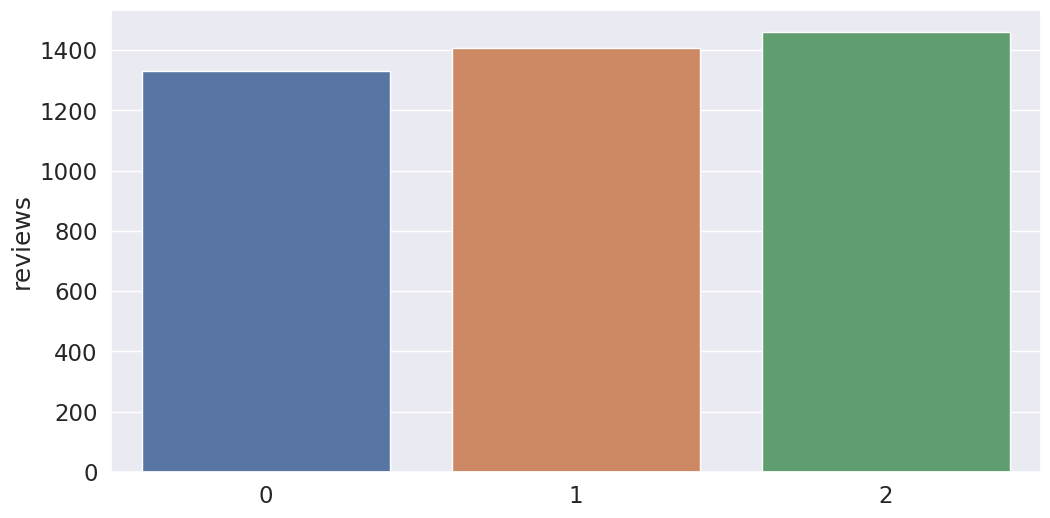

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

#for now we have 4200 rows of reviews.
x = df.sentiment.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('reviews')
plt.show()

In [93]:
sentences = df.content.values
labels = df.sentiment.values

In [94]:
from transformers import BertTokenizer
#using pretrained bert tokenizer
print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT Tokenizer


In [95]:
print("Original: ", sentences[0])
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
#tokenization time
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Tokenized:  ['for', 'whatever', 'reason', 'my', 'game', 'used', 'to', 'work', 'just', 'fine', 'except', 'for', 'cuts', '##cene', '##s', 'when', 'it', 'crashed', 'and', 'would', 'not', 'play', 'so', 'i', 'had', 'to', 'use', 'ge', '##force', 'but', 'now', 'it', 'just', 'refuses', 'to', 'open', 'it', 'opens', 'up', 'shows', 'a', 'black', 'screen', 'and', 'promptly', 'crashes', 'again', 'i', 'have', 'tried', 'un', '##ins', '##tal', '##ling', 'and', 'reins', '##tal', '##ling', 'took', 'about', 'three', 'hour', 'by', 'the', 'way', 'and', 'restart', '##ing', 'my', 'device', 'it', 'just', 'does', 'not', 'work', 'fun', 'game', '

In [96]:
#adding CLS and SEP
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True,
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors


Original:  for whatever reason my game used to work just fine except for cutscenes when it crashed and would not play so i had to use geforce but now it just refuses to open it opens up shows a black screen and promptly crashes again i have tried uninstalling and reinstalling took about three hour by the way and restarting my device it just does not work fun game though
Token IDs:  [101, 2005, 3649, 3114, 2026, 2208, 2109, 2000, 2147, 2074, 2986, 3272, 2005, 7659, 17968, 2015, 2043, 2009, 8007, 1998, 2052, 2025, 2377, 2061, 1045, 2018, 2000, 2224, 16216, 14821, 2021, 2085, 2009, 2074, 10220, 2000, 2330, 2009, 7480, 2039, 3065, 1037, 2304, 3898, 1998, 13364, 19119, 2153, 1045, 2031, 2699, 4895, 7076, 9080, 2989, 1998, 19222, 9080, 2989, 2165, 2055, 2093, 3178, 2011, 1996, 2126, 1998, 23818, 2075, 2026, 5080, 2009, 2074, 2515, 2025, 2147, 4569, 2208, 2295, 102]


In [97]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  812


In [98]:
from keras.preprocessing.sequence import pad_sequences

#setting max length of sentence to 64
MAX_LEN = 64

print("Padding/Truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [99]:
input_ids[0]

array([  101,  2005,  3649,  3114,  2026,  2208,  2109,  2000,  2147,
        2074,  2986,  3272,  2005,  7659, 17968,  2015,  2043,  2009,
        8007,  1998,  2052,  2025,  2377,  2061,  1045,  2018,  2000,
        2224, 16216, 14821,  2021,  2085,  2009,  2074, 10220,  2000,
        2330,  2009,  7480,  2039,  3065,  1037,  2304,  3898,  1998,
       13364, 19119,  2153,  1045,  2031,  2699,  4895,  7076,  9080,
        2989,  1998, 19222,  9080,  2989,  2165,  2055,  2093,  3178,
        2011])

In [100]:
#empty list to store attention mask for each sentence
attention_mask = []
#go through each sentence in the input_ids
for sent in input_ids:
  #Create an attention mask for the current sentence
    #The mask is a binary list: 1 if the token is not a padding token, 0 otherwise
  att_mask = [int(token_id > 0) for token_id in sent]
  #append the attention mask for the current sentence to the attention_mask list
  attention_mask.append(att_mask)

In [101]:
#splitting data into training and testing sets
from sklearn.model_selection import train_test_split
#Train/Test Split
train_input, test_input, train_labels, test_labels = train_test_split(input_ids,labels, random_state=42, test_size=0.1)
#masks for first split
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)
#Second Split Train/Validation Split on training data
train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state= 43, test_size=0.15)
#masks for second split
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=43, test_size=0.15)

In [102]:
import numpy as np

#just showing shapes of different arrays or tensors
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (3213, 64)
Label:  (3213,)
Mask:  (3213, 64)

== Validation ==
Input:  (567, 64)
Label:  (567,)
Mask:  (567, 64)

== Test ==
Input:  (420, 64)
Label:  (420,)
Mask:  (420, 64)


In [103]:
#converting all the inputs and labels into torch tensors (required datatype)
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [104]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#for the dataloader later
batch_size = 16

#DataLoader for training set
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#Dataloader for validation set
validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#Dataloader for testing set
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [105]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [106]:
#get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
#architecture model
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [107]:
#AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, #learning rate, default is 5e-5
                  eps = 1e-8 #adam epsilon, default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [108]:
from transformers import get_linear_schedule_with_warmup

#Number of training epochs.
epochs = 15

#Total number of training steps is number of batches times number of epochs
total_steps = len(train_dataloader) * epochs

#create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [109]:
import numpy as np

#function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [110]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    #round it to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [111]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#store number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []

#measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    #for each epoch, perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    #Measure how long the training epoch takes.
    t0 = time.time()

    #Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    #For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        #Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            #Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #batch contains three pytorch tensors:
        #input ids
        #attention masks
        #labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #clear any previously calculated gradients before performing backward pass
        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        #accumulate the training loss over all of the batches so we can calculate the average loss at the end.
        #loss is a Tensor containing single value
        #item function just returns the Python value from the tensor.
        total_train_loss += loss.item()

        #Perform a backward pass to calculate the gradients.
        loss.backward()

        #clip the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        #update parameters and take a step using the computed gradient.
        optimizer.step()

        #update the learning rate.
        scheduler.step()

    #calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    #measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    #put the model in evaluation mode, the dropout layers behave differently during evaluation.
    model.eval()

    #tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    #evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits

        #accumulate the validation loss.
        total_eval_loss += loss.item()

        #move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #calculate the accuracy for this batch of test sentences.
        #ccumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    #report the final accuracy for this validation
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    #measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    #record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

#for the training and validation, I took reference from : https://github.com/mitmedialab/bert-slu/blob/master/train.py


======== Epoch 1 / 15 ========
Training...
  Batch    40  of    201.    Elapsed: 0:00:08.
  Batch    80  of    201.    Elapsed: 0:00:16.
  Batch   120  of    201.    Elapsed: 0:00:24.
  Batch   160  of    201.    Elapsed: 0:00:32.
  Batch   200  of    201.    Elapsed: 0:00:40.

  Average training loss: 0.92
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.55
  Validation Loss: 0.90
  Validation took: 0:00:02

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    201.    Elapsed: 0:00:07.
  Batch    80  of    201.    Elapsed: 0:00:15.
  Batch   120  of    201.    Elapsed: 0:00:22.
  Batch   160  of    201.    Elapsed: 0:00:30.
  Batch   200  of    201.    Elapsed: 0:00:37.

  Average training loss: 0.70
  Training epcoh took: 0:00:37

Running Validation...
  Accuracy: 0.61
  Validation Loss: 0.85
  Validation took: 0:00:02

======== Epoch 3 / 15 ========
Training...
  Batch    40  of    201.    Elapsed: 0:00:07.
  Batch    80  of    201.    Elapsed: 0:00:15

In [112]:
import pandas as pd


#create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

#use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats = df_stats.round(2)
#display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.92,0.90,0.55,0:00:41,0:00:02
2,0.70,0.85,0.61,0:00:37,0:00:02
3,0.53,0.93,0.62,0:00:37,0:00:02
4,0.35,1.18,0.58,0:00:38,0:00:02
5,0.20,1.54,0.61,0:00:37,0:00:02
6,0.13,2.02,0.61,0:00:37,0:00:02
7,0.09,2.11,0.62,0:00:37,0:00:02
8,0.07,2.37,0.60,0:00:37,0:00:02
9,0.04,2.57,0.60,0:00:37,0:00:02


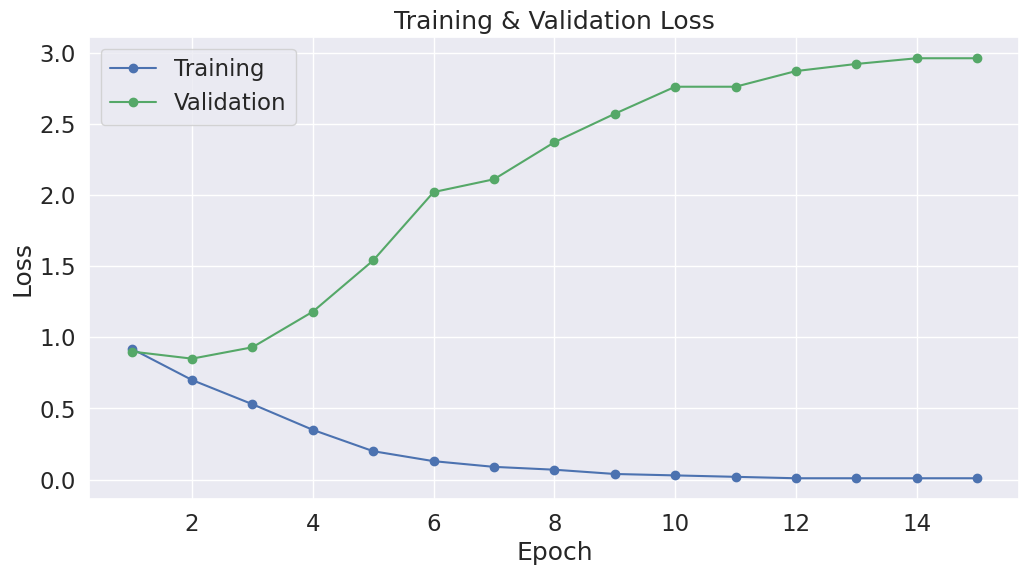

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

#increase size and font of the plot
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

#plotting the curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

#labelling
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [114]:
#print the number of test sentences to be predicted
print("Predicting labels for {:,} test sentences".format(len(test_input)))

#set the model to evaluation mode
model.eval()

#initialize lists to store predictions and true labels
prediction, true_labels = [], []

#iterate over batches in the test data loader
for batch in test_dataloader:
    #move the batch to the specified device (e.g., GPU)
    batch = tuple(t.to(device) for t in batch)

    #unpack the batch into input IDs, input mask, and labels
    b_input_ids, b_input_mask, b_labels = batch

    #disable gradient computation during inference (no backpropagation)
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    #retrieve the logits from the model outputs
    logits = outputs[0]
    #detach the logits from the computation graph and move to CPU
    logits = logits.detach().cpu().numpy()
    #move label IDs to CPU and convert to a numpy array
    label_ids = b_labels.to('cpu').numpy()

    #append the predictions and true labels to their respective lists
    prediction.append(logits)
    true_labels.append(label_ids)

print(" DONE.")


Predicting labels for 420 test sentences
 DONE.


In [115]:
import numpy as np
import pandas as pd

#convert lists to NumPy arrays
prediction_array = np.concatenate(prediction, axis=0)
true_labels_array = np.concatenate(true_labels, axis=0)

#create a DataFrame
df = pd.DataFrame({
    'Predicted_Labels': np.argmax(prediction_array, axis=1),
    'True_Labels': true_labels_array
})

print(df)

     Predicted_Labels  True_Labels
0                   1            1
1                   1            1
2                   1            1
3                   1            2
4                   1            0
..                ...          ...
415                 2            2
416                 1            0
417                 0            0
418                 1            2
419                 2            2

[420 rows x 2 columns]


In [116]:
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score

#convert lists to NumPy arrays
flat_prediction = np.concatenate(prediction, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

#calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("MATTHEWS_CC: %.3f" % mcc)

#calculate Accuracy
acc = accuracy_score(flat_true_labels, np.argmax(flat_prediction, axis=1))

print("ACCURACY: %.3f" % acc)

#calculate Precision
precision = precision_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("PRECISION: %.3f" % precision)

#calculate Recall
recall = recall_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("RECALL: %.3f" % recall)

#calculate F1-Score
f1 = f1_score(flat_true_labels, np.argmax(flat_prediction, axis=1), average='weighted')

print("F1 SCORE: %.3f" % f1)

MATTHEWS_CC: 0.458
ACCURACY: 0.638
PRECISION: 0.653
RECALL: 0.638
F1 SCORE: 0.641


In [117]:
import pandas as pd
from sklearn.metrics import accuracy_score

#add a column to df indicating whether the prediction is correct
df['Correct_Prediction'] = df['True_Labels'] == df['Predicted_Labels']

#calculate accuracy
accuracy = accuracy_score(df['True_Labels'], df['Predicted_Labels'])
print("Overall Accuracy: {:.2%}".format(accuracy))

#amount of correct predictions for each sentiment class
for sentiment_class in [0, 1, 2]:  #0 for negative, 1 for neutral, 2 for positive
    correct_predictions = df[df['Correct_Prediction'] & (df['True_Labels'] == sentiment_class)].shape[0]
    total_samples = df[df['True_Labels'] == sentiment_class].shape[0]
    print("Correct {} predictions: {}/{}".format(sentiment_class, correct_predictions, total_samples))

Overall Accuracy: 63.81%
Correct 0 predictions: 85/144
Correct 1 predictions: 96/149
Correct 2 predictions: 87/127


In [118]:
df.head(10)

,Predicted_Labels,True_Labels,Correct_Prediction
0,1,1,True
1,1,1,True
2,1,1,True
3,1,2,False
4,1,0,False
5,1,1,True
6,2,2,True
7,0,0,True
8,2,2,True
9,0,1,False


In [119]:
#drop the 'Correct_Prediction' column if not needed
df = df.drop(columns=['Correct_Prediction'])
df.head(10)

,Predicted_Labels,True_Labels
0,1,1
1,1,1
2,1,1
3,1,2
4,1,0
5,1,1
6,2,2
7,0,0
8,2,2
9,0,1


In [127]:
def test_review(review_text, model, tokenizer, max_length):
    #tokenize and preprocess the review
    encoded_review = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    #extract token IDs and attention mask
    input_ids = encoded_review['input_ids']
    attention_mask = encoded_review['attention_mask']

    #ensure the tensors are on the appropriate device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    #make predictions using the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    #get the predicted label (argmax of the logits)
    predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

In [128]:
#input text
# 0 negative
# 1 neutral
# 2 positive
review_text = "This game is ok, but there are multiple flaws with the game that hinder me from giving it five stars. at best i give it a three"

#Example usage
predicted_sentiment = test_review(review_text, model, tokenizer, max_length=64)
print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: 1


In [126]:
import os

output_dir = './GenshinModel_save/'

#create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

#save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./GenshinModel_save/


('./GenshinModel_save/tokenizer_config.json',
 './GenshinModel_save/special_tokens_map.json',
 './GenshinModel_save/vocab.txt',
 './GenshinModel_save/added_tokens.json')

In [123]:
#Mount Google Drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
#copy the model files to the target directory
!cp -r ./model_save/ "/content/drive/My Drive/"